# Image Classification Model Using LeNet

In [25]:
import os
from torchvision import datasets, transforms 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

In [26]:
class HarDataset(Dataset):
    def __init__(self, root_dir, data, transform=None):
        self.root_dir = root_dir
        self.data_df = data
        self.transform = transform
        self.label_map = self._create_label_map()

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.data_df.iloc[idx, 1]
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, label

    def _create_label_map(self):
        unique_labels = sorted(self.data_df['label'].unique())
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        return label_map

In [27]:
# Define transforms for data augmentation

# Use this for colored images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ])

# Use this for BnW images
# transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.Grayscale(num_output_channels=1),  # Convert to black and white
#     transforms.ToTensor(),
# ])

In [28]:

# Define the paths 

path = r'/Users/azeez/Desktop/AI/Personal Projects/GitHub/Computer-Vision-using-PyTorch/Human Action Recognition' 
folder = 'train' 
activity = 'cycling' 
img_name = 'Image_93.jpg' 

# construct the full image path 
img_path = os.path.join(path, folder, activity, img_name)

# Open and display the image 
image = Image.open(img_path)
image.show() 


In [29]:
print(image.size)

(385, 131)


In [30]:

print(image.mode)

RGB


In [31]:
train_root_dir = r'/Users/azeez/Desktop/AI/Personal Projects/GitHub/Computer-Vision-using-PyTorch/Human Action Recognition/train'
# train_file = r'C:\Users\Deepak\Downloads\Computer Vision Resources\Human Action Recognition\Modified_Training_set.csv'
test_root_dir = r'/Users/azeez/Desktop/AI/Personal Projects/GitHub/Computer-Vision-using-PyTorch/Human Action Recognition/test'
# test_file = r'C:\Users\Deepak\Downloads\Computer Vision Resources\Human Action Recognition\Reduced_Testing_set.csv'

In [32]:
# Apply the transforms to the train and test data 
train_data = datasets.ImageFolder(root=train_root_dir, transform=transform )
test_data = datasets.ImageFolder(root=test_root_dir, transform=transform)

In [33]:
print(train_data.classes)
num_classes = len(train_data.classes)
print(num_classes)

['cycling', 'dancing', 'drinking', 'eating', 'sitting']
5


In [34]:
from collections import Counter 

Counter({'dancing': 714, 'drinking': 714, 'sitting': 714, 'eating': 714, 'cycling': 714})


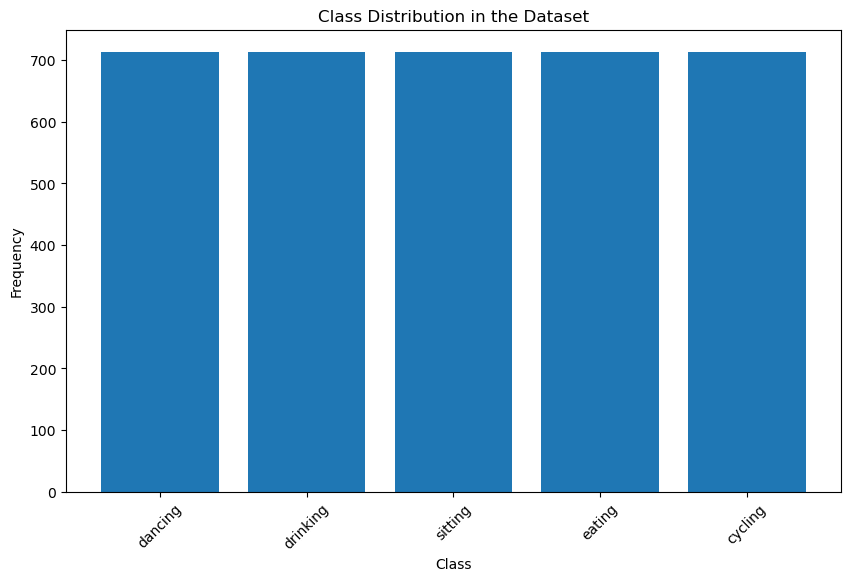

In [35]:
# checking class distribution 

class_distribution = Counter([label for label in os.listdir(train_root_dir) if os.path.isdir(os.path.join(train_root_dir, label))])

# Get the count of images in each class 
for label in class_distribution:
    class_distribution[label] = len(os.listdir(os.path.join(train_root_dir, label)))
    
# Print the class distribution 
print(class_distribution)

# Plotting the class distribution 
plt.figure(figsize=(10,6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45) # Rotate class labels for better readability 
plt.show()

### LeNet Architecture 

In [36]:
# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=0, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=0, stride=1)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [37]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
device

device(type='cpu')

In [39]:
# Initialize LeNet-5 model
model = LeNet5().to(device)

In [40]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
# Define data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [47]:
# Initialize the lists to store train and test loss for each epoch 
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
best_accuracy = torch.inf 
patience = 5 
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # for models that return auxillary outputs 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss) # store the test loss for this epoch 
    train_accuracy = 100. * correct / total
    
    print(f'Epoch [{epoch + 1}/{num_epochs}],'
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%'
          )

    # Evaluate the model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple): 
               outputs = outputs[0]  # for models that return auxillary outputs  
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss) # store the test loss for this epoch 
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after two more epochs
    if test_loss < best_accuracy: 
        best_accuracy = test_loss 
        epochs_since_best = 0 
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model 
        print(f'New best accuracy: {best_accuracy:.2f}%')
    else: 
        epochs_since_best += 1
        if epochs_since_best > patience:
            print("Stopping early: no improvement after five consecutive epochs.")
            break 


100%|██████████| 112/112 [00:03<00:00, 34.07it/s]


Epoch [1/20],Train Loss: 0.6436, Train Accuracy: 76.16%
Test Loss: 1.2323, Test Accuracy: 57.78%
New best accuracy: 1.23%


100%|██████████| 112/112 [00:02<00:00, 44.05it/s]


Epoch [2/20],Train Loss: 0.5541, Train Accuracy: 80.78%
Test Loss: 1.3034, Test Accuracy: 56.51%


100%|██████████| 112/112 [00:02<00:00, 39.53it/s]


Epoch [3/20],Train Loss: 0.4931, Train Accuracy: 83.00%
Test Loss: 1.3935, Test Accuracy: 56.35%


100%|██████████| 112/112 [00:02<00:00, 40.43it/s]


Epoch [4/20],Train Loss: 0.4176, Train Accuracy: 85.35%
Test Loss: 1.6714, Test Accuracy: 55.40%


100%|██████████| 112/112 [00:02<00:00, 44.38it/s]


Epoch [5/20],Train Loss: 0.3555, Train Accuracy: 87.90%
Test Loss: 1.6217, Test Accuracy: 55.71%


100%|██████████| 112/112 [00:02<00:00, 41.39it/s]


Epoch [6/20],Train Loss: 0.2992, Train Accuracy: 89.64%
Test Loss: 1.7433, Test Accuracy: 55.71%


100%|██████████| 112/112 [00:02<00:00, 44.06it/s]


Epoch [7/20],Train Loss: 0.2168, Train Accuracy: 92.66%
Test Loss: 1.9344, Test Accuracy: 55.08%
Stopping early: no improvement after five consecutive epochs.


In [48]:
print(train_losses)

[0.6436492255223649, 0.5540718854005847, 0.49308759147035225, 0.4175683202754174, 0.3554886520973274, 0.2992162721763764, 0.2168285357100623]


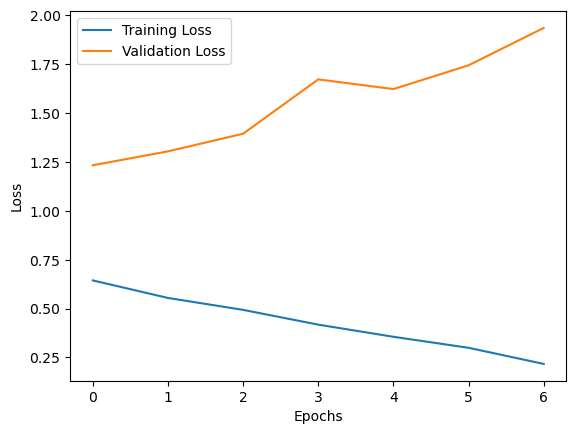

In [50]:
# Plotting the training and validation losses 

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
output_label_map = {v: k for k, v in train_data.class_to_idx.items()}

# output_label_map = {val: key for (key, val) in train_data.label_map.items()}

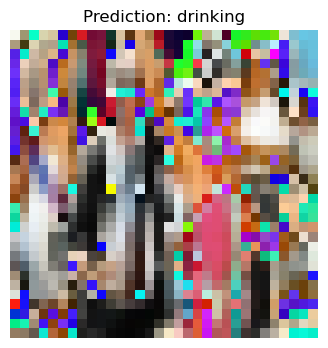

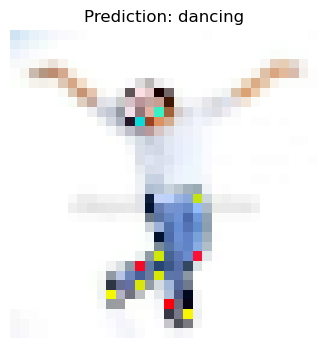

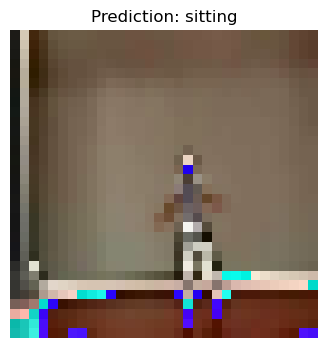

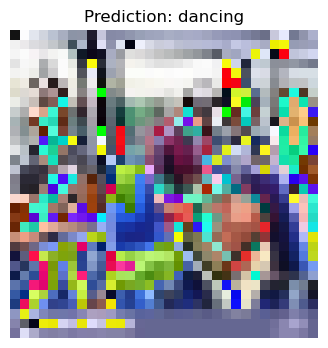

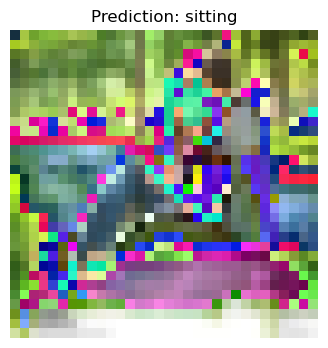

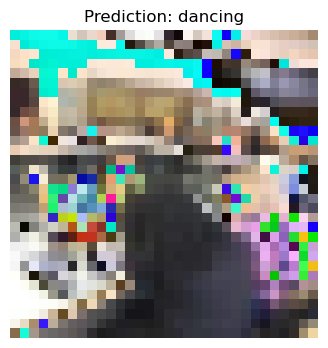

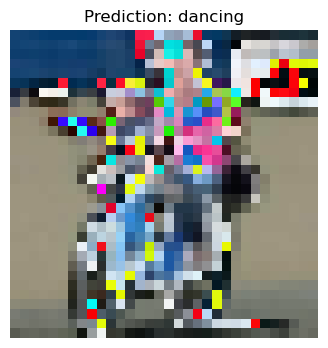

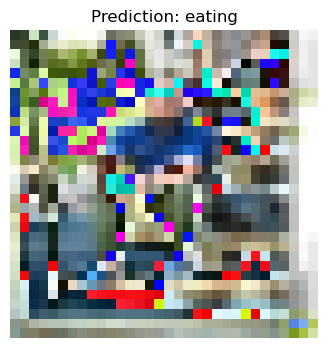

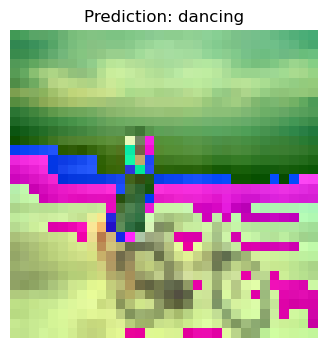

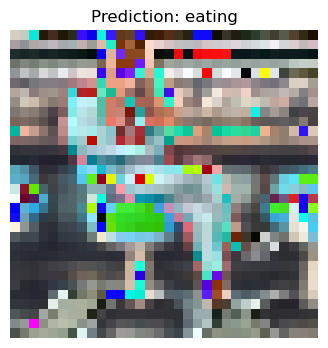

In [57]:
import random

# Randomly select 10 indices from the dataset
sample_indices = random.sample(range(len(test_data)), 10)

# Loop over sampled indices
for idx in sample_indices:
    image_true, label = test_data[idx]  # Returns (image, class index)

    # Save the original image for plotting
    image_to_plot = transforms.ToPILImage()(image_true)

    # Transform and add batch dimension
    image = image_true.unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(image)

    predicted_class = torch.argmax(output, dim=1).item()

    # Plot image with predicted label
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_plot)
    plt.title(f'Prediction: {output_label_map[predicted_class]}')
    plt.axis('off')
    plt.show()

In [56]:
# for idx, row in test_data.sample(10).iterrows(): 

#     img_path = os.path.join(test_root_dir, row['filename'])  
#     image_true = Image.open(img_path)  # Open the image file

#     # Transform the image and add a batch dimension
#     image = transform(image_true).unsqueeze(0).to(device) 

#     # Pass the image through the model without computing gradients
#     with torch.no_grad():
#         output = model(image) 

#     # Get the predicted class label by finding the maximum in the output tensor
#     predicted_class = torch.argmax(output).item()

#     # Plot the image along with the predicted class label
#     plt.figure(figsize=(4, 4))
#     plt.imshow(image_true)
#     plt.title(f'Prediction: {output_label_map[predicted_class]}')  # Display the predicted label
#     plt.show()  